In [1]:
%load_ext lab_black

In [2]:
# from starter code
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, desc
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [3]:
# from starter code
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

# Exploratory Climate Analysis

* Calculate the date 1 year ago from the last data point in the database

In [4]:
date_data = session.query(func.max(Measurement.date)).all()
pprint(date_data)

# Last date in DB is 2017-08-23, one year prior would be 2016-08-23

[('2017-08-23',)]


* Perform a query to retrieve the data and precipitation scores

In [5]:
precip_data = (
    session.query(Measurement.prcp, Measurement.date)
    .filter(
        Measurement.date >= dt.date(2016, 8, 23),
        Measurement.date <= dt.date(2017, 8, 23),
    )
    .all()
)

* Save the query results as a Pandas DataFrame and set the index to the date column

* Sort the dataframe by date

In [6]:
df_meas_precipdata_unclean = pd.DataFrame(
    precip_data, columns=["Precipitation", "Date"]
).dropna()
df_meas_precipdata_date_unclean = df_meas_precipdata_unclean["Date"]
df_meas_precipdata_date_clean = pd.DataFrame(
    pd.to_datetime(df_meas_precipdata_date_unclean)
)
df_meas_precipdata_precip = df_meas_precipdata_unclean["Precipitation"]
df_meas_precipdata_precipdf = pd.DataFrame(df_meas_precipdata_precip)
df_meas_precipdata_clean = df_meas_precipdata_date_clean.join(
    df_meas_precipdata_precipdf
).set_index("Date")
df_meas_precipdata_clean

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


* Use Pandas Plotting with Matplotlib to plot the data

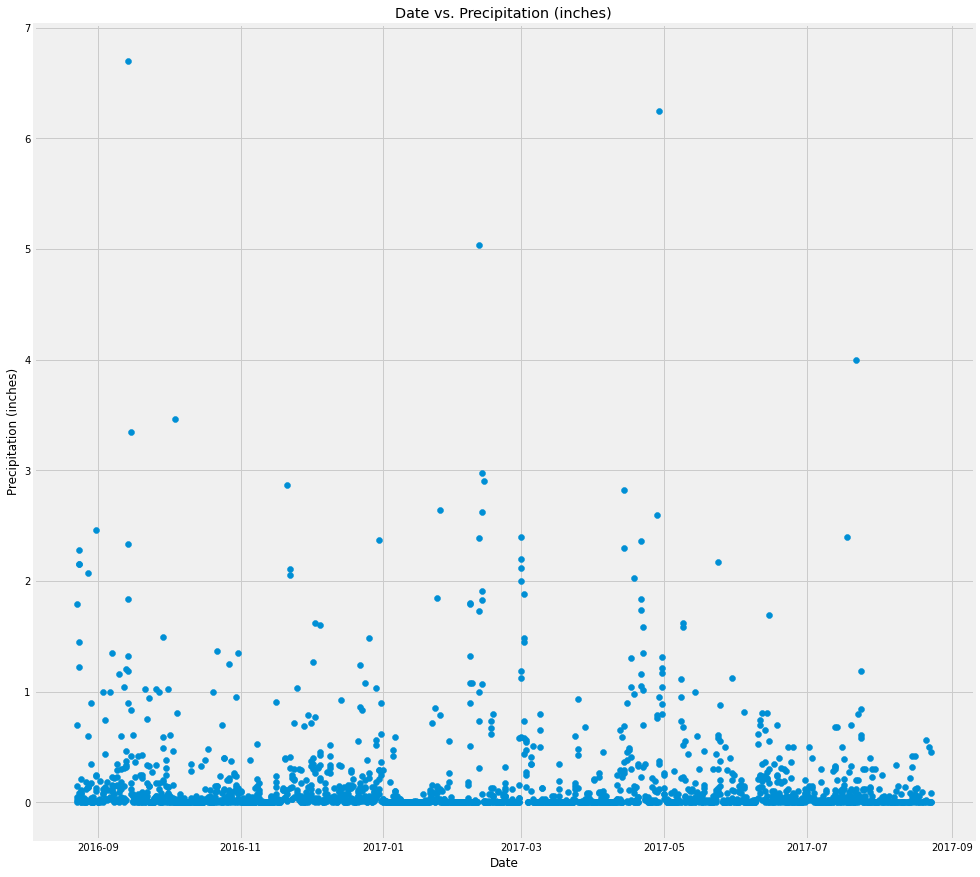

In [14]:
plt.title("Date vs. Precipitation (inches)")
x = df_meas_precipdata_clean.index
y = df_meas_precipdata_clean["Precipitation"]
plt.scatter(x, y)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.rcParams["figure.figsize"] = (15, 15)
plt.show()

* Use Pandas to calcualte the summary statistics for the precipitation data

In [8]:
df_meas_precipdata_clean.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

* Design a query to show how many stations are available in this dataset?

In [9]:
unique_stations = session.query(func.count(distinct(Measurement.station))).all()
pprint(unique_stations)

[(9,)]


*What are the most active stations? (i.e. what stations have the most rows)?
*List the stations and the counts in descending order.

In [10]:
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(desc(func.count(Measurement.station)))
    .all()
)
pprint(active_stations)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


* Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?

In [11]:
temp_stations = (
    session.query(
        Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .group_by(Measurement.station)
    .order_by(desc(func.count(Measurement.station)))
    .limit(1)
    .all()
)
pprint(temp_stations)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


* Choose the station with the highest number of temperature observations.
* Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [12]:
temp_active = (
    session.query(Measurement.station, Measurement.tobs, Measurement.date)
    .filter(Measurement.station == "USC00519281")
    .filter(
        Measurement.date >= dt.date(2016, 8, 23),
        Measurement.date <= dt.date(2017, 8, 23),
    )
    .all()
)
temp_active_df_unclean = pd.DataFrame(temp_active)
temp_active_date = temp_active_df_unclean["date"]
temp_active_date_clean = pd.DataFrame(pd.to_datetime(temp_active_date))
temp_active_df_unclean2 = temp_active_df_unclean
temp_active_df_unclean3 = temp_active_df_unclean2.drop(columns="date")
temp_active_df = (temp_active_df_unclean3.join(temp_active_date_clean)).set_index(
    "date"
)
temp_active_df

,station,tobs
date,,
2016-08-23,USC00519281,77.0
2016-08-24,USC00519281,77.0
2016-08-25,USC00519281,80.0
2016-08-26,USC00519281,80.0
2016-08-27,USC00519281,75.0
...,...,...
2017-08-14,USC00519281,77.0
2017-08-15,USC00519281,77.0
2017-08-16,USC00519281,76.0


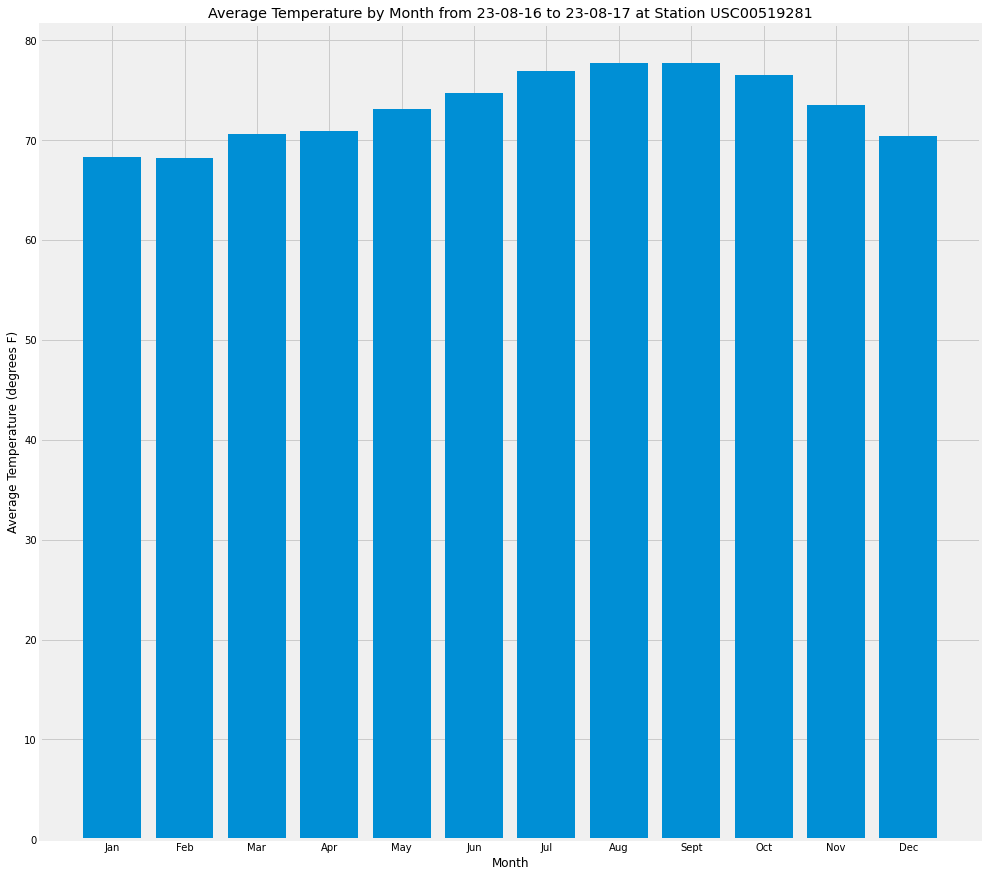

In [13]:
temp_active_monthly_df = temp_active_df.groupby(
    by=[temp_active_df.index.month]
).mean()  # groups by month but by 01 to 12
tx = temp_active_monthly_df.index
ty = temp_active_monthly_df["tobs"]
plt.bar(
    tx,
    ty,
    tick_label=[
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sept",
        "Oct",
        "Nov",
        "Dec",
    ],
)
plt.xlabel("Month")
plt.ylabel("Average Temperature (degrees F)")
plt.title(
    "Average Temperature by Month from 23-08-16 to 23-08-17 at Station USC00519281"
)
plt.show()
# Histogram seemed meaningless to me here; much better to show this properly broken out by month